# Homework 04
---
[mlbookcamp 04-evalutation](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/homework.md)

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [188]:
DATAPATH = "/dataset/CreditScoring.csv"

### Downloading data

In [189]:
%%bash -s "$DATAPATH"
# Downloads data if not available.
if [[ -f "$1" ]]
    then
        echo 'Data already there.';
    else
        echo 'Downloading data';
        wget -O "$1" https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
fi

Data already there.


## Preparation
Code available at https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/homework-4-starter.ipynb

In [190]:
data = pd.read_csv(DATAPATH)
data.columns = data.columns.str.lower()
data.head().T

,0,1,2,3,4
status,1,1,2,1,1
seniority,9,17,10,0,0
home,1,1,2,1,1
time,60,60,36,60,36
age,30,58,46,24,26
marital,2,3,2,1,1
records,1,1,2,1,1
job,3,1,3,1,1
expenses,73,48,90,63,46
income,129,131,200,182,107


In [191]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

data.status = data.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

data.home = data.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

data.marital = data.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

data.records = data.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

data.job = data.job.map(job_values)

In [192]:
for c in ['income', 'assets', 'debt']:
    data[c] = data[c].replace(to_replace=99999999, value=0)

In [193]:
data = data[data.status != 'unk'].reset_index(drop=True)

In [194]:
data['default'] = (data.status == 'default').astype(int)
del data['status']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1


In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns='default'),
                                                    data.default,
                                                    test_size=0.4,
                                                    random_state=1)

X_test, X_val, Y_test, Y_val = train_test_split(X_test,
                                                Y_test,
                                                test_size=0.5,
                                                random_state=1)

In [196]:
np.round([len(X_train)/len(data), len(X_test)/len(data), len(X_val)/len(data)], 2)

array([0.6, 0.2, 0.2])

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the "default" variable
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `seniority`
- `time`
- `income`
- `debt`

In [197]:
from sklearn.metrics import roc_auc_score

query_features = ['seniority', 'time', 'income', 'debt']
dict_scores = {}
for feature in query_features:
    auc_score = roc_auc_score(Y_train, X_train[feature])
    auc_score = auc_score if auc_score >= 0.5 else roc_auc_score(Y_train, -X_train[feature])
    dict_scores[feature] = auc_score
dict_scores

{'seniority': 0.6989553405441946,
 'time': 0.5547440989240043,
 'income': 0.6710836713424596,
 'debt': 0.5025745028449101}

In [198]:
sorted(dict_scores, key=dict_scores.get, reverse=True)

['seniority', 'income', 'time', 'debt']

## Training the model
From now on, use these columns only:
    
    ['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply `one-hot-encoding` using `DictVectorizer` and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [199]:
feature_columnns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

X_train = X_train[feature_columnns]
X_test = X_test[feature_columnns]
X_val = X_val[feature_columnns]

In [200]:
from sklearn.feature_extraction import DictVectorizer

dict_vect = DictVectorizer(sparse=False)
X_train_preprocessed = dict_vect.fit_transform(X_train.to_dict(orient='records'))
X_test_preprocessed = dict_vect.transform(X_test.to_dict(orient='records'))
X_val_preprocessed = dict_vect.transform(X_val.to_dict(orient='records'))

In [201]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_preprocessed, Y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [202]:
yhat = model.predict_proba(X_val_preprocessed)[:, 1]
round(roc_auc_score(Y_val, yhat), 3)

0.783

## Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [203]:
from sklearn.metrics import precision_score, recall_score

yhat_proba = model.predict_proba(X_val_preprocessed)[:, 1]

score_dict = {'threshold': [], 'precision': [], 'recall': []}

for threshold in np.arange(0.0, 1.0, step=0.01):
    yhat = (yhat_proba >= threshold) * 1
    score_dict['threshold'].append(threshold)
    score_dict['precision'].append(precision_score(Y_val, yhat, zero_division=1.0))
    score_dict['recall'].append(recall_score(Y_val, yhat, zero_division=1.0))

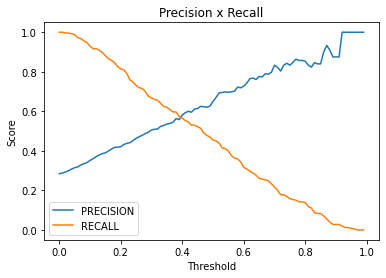

In [204]:
score_df = pd.DataFrame(score_dict).set_index('threshold')
plt.plot(score_df.index, score_df.precision, label='PRECISION')
plt.plot(score_df.index, score_df.recall, label='RECALL')
plt.title('Precision x Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

 
Where  is precision and  is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01



In [205]:
score_df['F1'] = 2* (score_df.precision * score_df.recall) / (score_df.precision + score_df.recall)
score_df.sort_values(by='F1', ascending=False)

,precision,recall,F1
threshold,,,
0.38,0.563433,0.596838,0.579655
0.33,0.524272,0.640316,0.576512
0.30,0.505988,0.667984,0.575809
0.35,0.535836,0.620553,0.575092
0.31,0.509146,0.660079,0.574871
...,...,...,...
0.95,1.000000,0.007905,0.015686
0.96,1.000000,0.003953,0.007874
0.97,1.000000,0.000000,0.000000


## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

In [206]:
df_full_x_train = pd.concat([X_train, X_test, X_val])
df_full_y_train = pd.concat([Y_train, Y_test, Y_val])

In [211]:
from sklearn.model_selection import KFold

score_list = []
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_x_train, df_full_y_train):
    X_train = df_full_x_train.iloc[train_idx]
    X_val = df_full_x_train.iloc[val_idx]
    Y_train = df_full_y_train.iloc[train_idx]
    Y_val = df_full_y_train.iloc[val_idx]
    model.fit(dict_vect.fit_transform(X_train.to_dict(orient='records')), Y_train)
    yhat = model.predict_proba(dict_vect.transform(X_val.to_dict(orient='records')))[:, 1]
    score_list.append(roc_auc_score(Y_val, yhat))

In [212]:
np.mean(score_list), np.std(score_list)

(0.8067842103984404, 0.00987951172434417)

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [213]:
score_dict = {'C': [], 'K': [], 'score': []}

for C in [0.01, 0.1, 1, 10]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for K, (train_idx, val_idx) in enumerate(kfold.split(df_full_x_train, df_full_y_train)):
        X_train = df_full_x_train.iloc[train_idx]
        X_val = df_full_x_train.iloc[val_idx]
        Y_train = df_full_y_train.iloc[train_idx]
        Y_val = df_full_y_train.iloc[val_idx]
        
        model.fit(dict_vect.fit_transform(X_train.to_dict(orient='records')), Y_train)
        yhat = model.predict_proba(dict_vect.transform(X_val.to_dict(orient='records')))[:, 1]
        
        score_dict['C'].append(C)
        score_dict['K'].append(K)
        score_dict['score'].append(roc_auc_score(Y_val, yhat))

score_df = pd.DataFrame(score_dict)
score_df

,C,K,score
0,0.01,0,0.814424
1,0.01,1,0.795750
2,0.01,2,0.792945
3,0.01,3,0.794228
4,0.01,4,0.802479
5,0.10,0,0.819207
6,0.10,1,0.800008
7,0.10,2,0.797632
8,0.10,3,0.798563
9,0.10,4,0.817928


In [217]:
score_df.pivot_table(index='C', values='score', aggfunc=['mean', 'std']).round(3).reset_index().sort_values(by=[('mean', 'score'), ('std', 'score'), 'C'], ascending=[False, False, True])

,C,mean,std
,,score,score
1,0.10,0.807,0.011
2,1.00,0.807,0.011
3,10.00,0.807,0.011
0,0.01,0.800,0.009
